In [79]:
from feature_extractor import *
from preprocessor import *

import matplotlib.pyplot as plt
import numpy as np


In [80]:
#only for ipynb
from IPython.display import clear_output, Image, display
import PIL.Image
import io

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

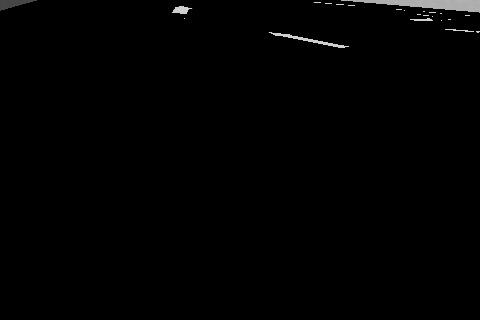

In [81]:
filename = 'samples/s20.jpg'
rawImg = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
src = np.copy(rawImg)
showarray(src)

(320, 480)


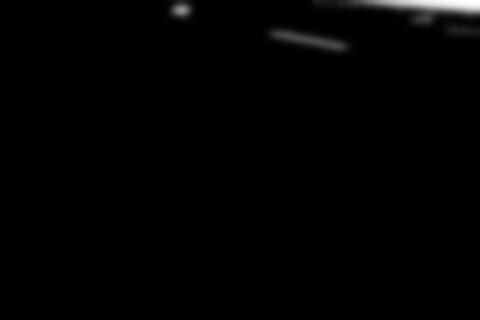

In [82]:
otsu_thresh = applyOtsu(src)
kSize = 25
src = cv2.GaussianBlur(otsu_thresh,(kSize,kSize),0)
print(src.shape)
showarray(src)

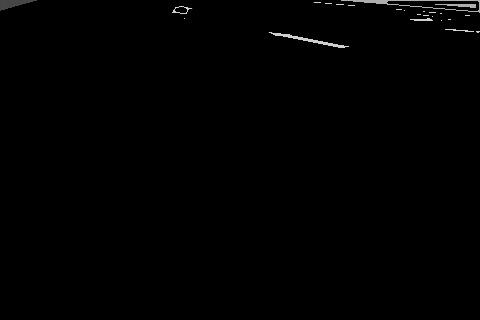

In [102]:


src = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

#Transform source image to gray if it is not already
if len(src.shape) != 2:
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
else:
    gray = src

thresh = applyOtsu(rawImg)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
hierarchy = hierarchy[0]

for i, c in enumerate(contours):
    if hierarchy[i][2] < 0 and hierarchy[i][3] < 0:
        cv2.drawContours(src, contours, i, (0, 0, 255), 2)
    else:
        cv2.drawContours(src, contours, i, (0, 255, 0), 2)
#write to the same directory

# Display the image

showarray(src)


In [84]:
t = len(np.where(otsu_thresh>0)[0])

69.15 [<feature_extractor.line object at 0x00000248DF114970>, <feature_extractor.line object at 0x00000248DF1146A0>, <feature_extractor.line object at 0x00000248DF3B5280>, <feature_extractor.line object at 0x00000248DFB9C550>, <feature_extractor.line object at 0x00000248DF51ED60>, <feature_extractor.line object at 0x00000248DFB8CC40>, <feature_extractor.line object at 0x00000248DFB8CB80>, <feature_extractor.line object at 0x00000248DF3834F0>, <feature_extractor.line object at 0x00000248DFC19A60>, <feature_extractor.line object at 0x00000248DFC19790>]


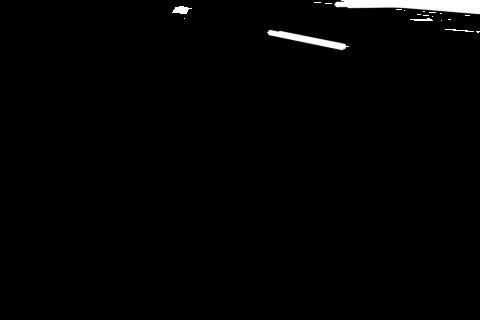

In [85]:

lineCp = np.copy(otsu_thresh)

li =openCV_houghlines(lineCp, int_thresh=int(0.025*t), minPoint_line=int(0.03*t), maxLine_gap=int(0.04*t))[0]
print(0.05*t, li)
showarray(lineCp)

In [86]:
vertical_lines = rampVerticalHelper(li, angleThreshold=25)

In [87]:
for line in vertical_lines:
    line.print_()

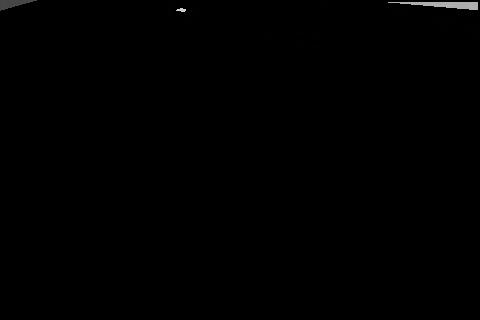

In [88]:
vLineCopy = np.copy(src)
vLineImg = cv2.cvtColor(vLineCopy, cv2.COLOR_GRAY2BGR)
for l in vertical_lines:
    cv2.line(vLineImg, (l.vertex1[0], src.shape[0]-l.vertex1[1]), (l.vertex2[0], src.shape[0]-l.vertex2[1]), (255,255,255), 3, cv2.LINE_AA)
showarray(vLineImg)

334 480 0 42


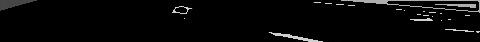

In [103]:

blobs = extract_blob(src)
largestBlob = getLblob(blobs)
testy1 = largestBlob.lowerY
testy2 = largestBlob.upperY

testx1 = largestBlob.lowerX
testx2 = largestBlob.upperX
print(testx1, testx2, testy1, testy2)
slice = make_copy(src,0, testy2, 0, testx2)
showarray(slice)

In [90]:

#take s20
# apply otsu
#extract blobs
#draw bounding rectangles
blobs = extract_blob(src)

In [91]:
#TODO: Make sure to differentiate between the wall and the arrow

In [92]:
#TODO :add to preprocessor
cannyEdge = cv2.Canny(slice, 10, 200, None, 5)
outline = cannyEdge 
showarray(outline)

In [93]:
def drawLines(img, lines):
    src = np.copy(img)
    for i in lines:
        cv2.line(src, (i.vertex1[0],img.shape[0]-i.vertex1[1]), (i.vertex2[0],img.shape[0]-i.vertex2[1]), (0,0,0), 3, cv2.LINE_AA)
    return src

In [94]:
cdst = np.copy(outline)

error_factor = 4
image_perimeter = np.where(cdst>0)[0].shape[0]
minPoints_in_long_line = int(image_perimeter*float((8-error_factor)/29))
intersection_threshold_long = int(0.5*minPoints_in_long_line)
max_gap_lines_long = int(0.9*minPoints_in_long_line)

print(image_perimeter, minPoints_in_long_line, intersection_threshold_long, max_gap_lines_long)
stem_lines, height= openCV_houghlines(cdst, r_res=1, theta_res=np.pi/180, int_thresh=intersection_threshold_long, \
                                  l=None, minPoint_line=minPoints_in_long_line, maxLine_gap=max_gap_lines_long)

print("Originally has %i lines"%(len(stem_lines)))
#Filter most suitable lines
bestFitStem = removeDup_sortLen(stem_lines,0.1,10)[:2]
for line in bestFitStem:
    line.print_()
showarray(cdst)


252 34 17 30
Originally has 5 lines
Line from (387,16) to (477,10) with gradient -0.066667, intercept 41.800000, length 90.199778, and angle -3.814075 degrees
Line from (387,18) to (477,17) with gradient -0.011111, intercept 22.300000, length 90.005555, and angle -0.636594 degrees


In [95]:
smImg = drawLines(outline,bestFitStem[:2])
showarray(smImg)

252 8 4 7
Originally has 4 lines
Line from (9,11) to (36,19) with gradient 0.296296, intercept 8.333333, length 28.160256, and angle 16.504361 degrees
Line from (176,8) to (185,8) with gradient 0.000000, intercept 8.000000, length 9.000000, and angle 0.000000 degrees


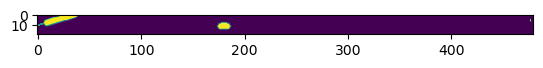

In [96]:
cdst = np.copy(smImg)

error_factor = 4
minPoints_in_line_short = int(image_perimeter*float((5-error_factor)/29))
intersection_threshold_short = int(0.5*minPoints_in_line_short)
max_gap_lines_short = int(0.9*minPoints_in_line_short)

print(image_perimeter, minPoints_in_line_short, intersection_threshold_short, max_gap_lines_short)
head_lines, height= openCV_houghlines(cdst, r_res=1, theta_res=np.pi/180, int_thresh=intersection_threshold_short, \
                                  l=None, minPoint_line=minPoints_in_line_short, maxLine_gap=max_gap_lines_short)

print("Originally has %i lines"%(len(head_lines)))
#Filter most suitable lines
bestFitHead = removeDup_sortLen(head_lines,0.1,10)

for line in bestFitHead:
    line.print_()
plt.imshow(cdst)
plt.show()
showarray(cdst)

In [97]:
ps = np.where(cdst>0)

for sLine in bestFitStem:
    vertex1_score = 0
    vertex2_score = 0
    for p_ in range(len(ps)):
        point = np.array([ps[1][p_],height-ps[0][p_]])
        vertex1_score += np.linalg.norm(sLine.vertex1-point)
        vertex2_score += np.linalg.norm(sLine.vertex2-point)
    print(vertex1_score, vertex2_score)
    if vertex1_score>vertex2_score:
        print('A',(sLine.vertex1,sLine.vertex2))
        b = bearing(sLine.vertex2[0],sLine.vertex2[1],sLine.vertex1[0],sLine.vertex1[1])
    else:
        print('B', (sLine.vertex2,sLine.vertex1))
        b = bearing(sLine.vertex1[0], sLine.vertex1[1],sLine.vertex2[0],sLine.vertex2[1])
    print(b)


725.0248272083414 905.1789880434899
B (array([477,  10], dtype=int32), array([387,  16], dtype=int32))
356.18592516570965
725.0027586206896 905.0088397466264
B (array([477,  17], dtype=int32), array([387,  18], dtype=int32))
359.3634064240365


In [98]:
bearing(21,47,164,211)

48.91315952498741

Long Lines Here

cdst = np.copy(outline)

lines_points , height= openCV_houghlines(cdst, r_res=1, theta_res=np.pi/180, int_thresh=60, l=None, minPoint_line=20, maxLine_gap=150)
#print(lines_points)
lines_Eqns = get_lines(lines_points)
print("lines detected: ", len(lines_points))
showarray(cdst)

Debug the short line distances here

In [99]:

for i in range(len(bestFitHead)):
    for j in range(i+1, len(bestFitHead)):
        x = intersects(cdst.shape, bestFitHead[i], bestFitHead[j])
        if x[0]==True:
            bestFitHead[i].print_()            
            bestFitHead[j].print_()
            vertex = x[1]

In [100]:
midpoint = (bestFitStem[0].get_midpoint()+bestFitStem[1].get_midpoint())/2
print(midpoint)
print(bearing(midpoint[0],midpoint[1],vertex[0],vertex[1]))

[432.    15.25]


NameError: name 'vertex' is not defined

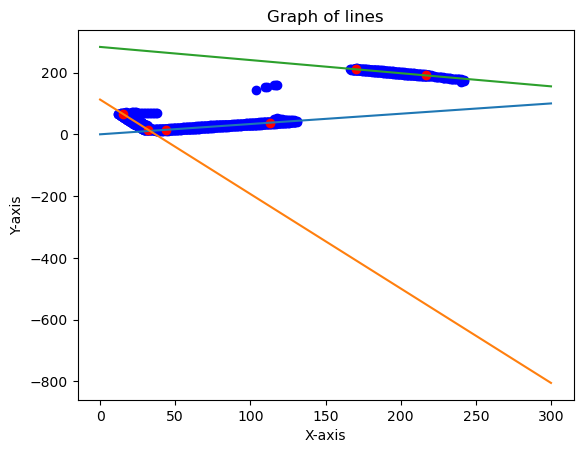

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



x_points=  list(ps[1])
y_points = list(height-ps[0])

plt.scatter(x_points, y_points, color='blue')

x_points = []
y_points = []

for l in bestFitHead:
    x_points.append(l.vertex1[0])
    x_points.append(l.vertex2[0])
    y_points.append(l.vertex1[1])
    y_points.append(l.vertex2[1])

plt.scatter(x_points, y_points, color='red')

x = np.linspace(0, 300, 100)

for l in bestFitHead:
    y = l.get_gradient() * x + l.get_intercept()
    plt.plot(x,y)


# plt.ylim(-30,height)
# plt.xlim(0,400)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Graph of lines')
plt.show()
